In [3]:
from PIL import Image
import sys
import os
import urllib
import tensorflow as tf
import tensorflow.contrib.tensorrt as trt
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import numpy as np
from tf_trt_models.classification import download_classification_checkpoint, build_classification_graph

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [9]:
MODEL = 'model'
CHECKPOINT_PATH = 'model'
NUM_CLASSES = 70
LABELS_PATH = './data/imagenet_labels_%d.txt' % NUM_CLASSES
IMAGE_PATH = './data/dog-yawning.jpg'

### Download the checkpoint and sample image

In [5]:
checkpoint_path = download_classification_checkpoint(MODEL, 'data')

KeyError: 'w251_finetune'

In [21]:
checkpoint_path = "data/w251_finetune/model"
checkpoint_path = "./data"

### Build the frozen graph

In [11]:
frozen_graph, input_names, output_names = build_classification_graph(
    model=MODEL,
    checkpoint=checkpoint_path,
    num_classes=NUM_CLASSES
)

KeyError: 'model'

In [22]:
from tensorflow.python.compiler.tensorrt import trt_convert

### Try saved model.
maybe this is not the right saved model file

In [34]:
#SAVED_MODEL_FILENAME_PB = "test.pb"
converter = trt_convert.TrtGraphConverter(input_saved_model_dir=checkpoint_path)
converter.convert()
converter.save(output_saved_model_dir)

with tf.Session() as sess:
    # First load the SavedModel into the session    
    tf.saved_model.loader.load(
        sess, [tf.saved_model.tag_constants.SERVING], output_saved_model_dir)
    output = sess.run([output_tensor], feed_dict={input_tensor: input_data})

OSError: SavedModel file does not exist at: data/{saved_model.pbtxt|saved_model.pb}

### try frozen graph

In [33]:
import tensorflow as tf
from tensorflow.python.compiler.tensorrt import trt_convert as trt
with tf.Session() as sess:
    # First deserialize your frozen graph:
    with tf.gfile.GFile("./data/test.pb", 'rb') as f:
        frozen_graph = tf.GraphDef()
        frozen_graph.ParseFromString(f.read())
    # Now you can create a TensorRT inference graph from your
    # frozen graph:
    converter = trt.TrtGraphConverter(
        input_graph_def=frozen_graph,
        nodes_blacklist=['logits', 'classes']) #output nodes
    trt_graph = converter.convert()
    # Import the TensorRT graph into a new graph and run:
    output_node = tf.import_graph_def(
        trt_graph,
        return_elements=['logits', 'classes'])
    sess.run(output_node)

ValueError: Input 0 of node bn_conv1/cond/ReadVariableOp/Switch was passed float from bn_conv1/gamma:0 incompatible with expected resource.

### try to load check point

In [4]:
import tensorflow as tf

tf.keras.backend.set_learning_phase(0)
with tf.Session() as sess:
    # First create a `Saver` object (for saving and rebuilding a
    # model) and import your `MetaGraphDef` protocol buffer into it:
    saver = tf.train.import_meta_graph("./data/model/model.ckpt.meta")
    # Then restore your training data from checkpoint files:
    #saver.restore(sess, "./data/model/")
    #saver.restore(sess, "./data/model/model.ckpt.data-00000-of-00001")
    #saver.restore(sess, "./data/model/model.ckpt.index")
    saver.restore(sess, "./data/model/model.ckpt")

    # Finally, freeze the graph:
    frozen_graph = tf.graph_util.convert_variables_to_constants(
        sess,
        tf.get_default_graph().as_graph_def(),
        output_node_names=['dense_2/Softmax'])

ValueError: Tensor name 'bn_conv1/cond/ReadVariableOp/Switch:1' is invalid.

In [27]:
import os
os.getcwd()

'/notebooks/tf_trt_models/examples/classification'

###  Try load Keras model directly (OOM)

In [38]:
from keras import backend as K
import tensorflow as tf
from  tensorflow.python.keras.models import load_model
# This line must be executed before loading Keras model.
K.set_learning_phase(0)

Using TensorFlow backend.
W1125 02:13:40.906852 547931684880 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



In [39]:
model = load_model('./data/resnet_finetune/model')

W1125 02:15:35.594734 547931684880 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1125 02:15:35.603329 547931684880 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1125 02:15:35.661564 547931684880 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Ones.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and 

ResourceExhaustedError: OOM when allocating tensor with shape[1,1,512,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node res3d_branch2a/kernel_5/Initializer/truncated_normal/TruncatedNormal (defined at <ipython-input-39-28820d199f4b>:1) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Original stack trace for 'res3d_branch2a/kernel_5/Initializer/truncated_normal/TruncatedNormal':
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.6/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.6/dist-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.6/asyncio/base_events.py", line 438, in run_forever
    self._run_once()
  File "/usr/lib/python3.6/asyncio/base_events.py", line 1451, in _run_once
    handle._run()
  File "/usr/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/usr/local/lib/python3.6/dist-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/usr/local/lib/python3.6/dist-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/usr/local/lib/python3.6/dist-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/usr/local/lib/python3.6/dist-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/usr/local/lib/python3.6/dist-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/usr/local/lib/python3.6/dist-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/usr/local/lib/python3.6/dist-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-39-28820d199f4b>", line 1, in <module>
    model = load_model('./data/resnet_finetune/model')
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/saving/save.py", line 146, in load_model
    return hdf5_format.load_model_from_hdf5(filepath, custom_objects, compile)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/saving/hdf5_format.py", line 212, in load_model_from_hdf5
    custom_objects=custom_objects)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/saving/model_config.py", line 55, in model_from_config
    return deserialize(config, custom_objects=custom_objects)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/layers/serialization.py", line 89, in deserialize
    printable_module_name='layer')
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py", line 192, in deserialize_keras_object
    list(custom_objects.items())))
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/network.py", line 1131, in from_config
    process_node(layer, node_data)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/network.py", line 1087, in process_node
    layer(flat_input_tensors[0], **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer.py", line 591, in __call__
    self._maybe_build(inputs)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer.py", line 1881, in _maybe_build
    self.build(input_shapes)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/layers/convolutional.py", line 165, in build
    dtype=self.dtype)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer.py", line 384, in add_weight
    aggregation=aggregation)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/training/tracking/base.py", line 663, in _add_variable_with_custom_getter
    **kwargs_for_getter)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer_utils.py", line 155, in make_variable
    shape=variable_shape if variable_shape.rank else None)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/variables.py", line 259, in __call__
    return cls._variable_v1_call(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/variables.py", line 220, in _variable_v1_call
    shape=shape)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/variables.py", line 198, in <lambda>
    previous_getter = lambda **kwargs: default_variable_creator(None, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/variable_scope.py", line 2495, in default_variable_creator
    shape=shape)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/variables.py", line 263, in __call__
    return super(VariableMetaclass, cls).__call__(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/resource_variable_ops.py", line 460, in __init__
    shape=shape)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/resource_variable_ops.py", line 604, in _init_from_args
    initial_value() if init_from_fn else initial_value,
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer_utils.py", line 135, in <lambda>
    init_val = lambda: initializer(shape, dtype=dtype)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py", line 526, in __call__
    shape, 0.0, stddev, dtype, seed=self.seed)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/random_ops.py", line 178, in truncated_normal
    shape_tensor, dtype, seed=seed1, seed2=seed2)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gen_random_ops.py", line 1013, in truncated_normal
    name=name)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/ops.py", line 3616, in create_op
    op_def=op_def)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/ops.py", line 2005, in __init__
    self._traceback = tf_stack.extract_stack()


### Optimized the graph with TensorRT

In [5]:
trt_graph = trt.create_inference_graph(
    input_graph_def=frozen_graph,
    outputs=output_names,
    max_batch_size=1,
    max_workspace_size_bytes=1 << 25,
    precision_mode='FP16',
    minimum_segment_size=50
)

### Create session and load graph

In [6]:
tf_config = tf.ConfigProto()
tf_config.gpu_options.allow_growth = True

tf_sess = tf.Session(config=tf_config)

tf.import_graph_def(trt_graph, name='')

tf_input = tf_sess.graph.get_tensor_by_name(input_names[0] + ':0')
tf_output = tf_sess.graph.get_tensor_by_name(output_names[0] + ':0')

### Download and preprocess image

In [14]:
IMAGE_PATH = './data/Beavis_and_butt_head.jpg'
IMAGE_PATH = './data/Alfalfa.jpg'
IMAGE_PATH = './data/Sunflower_test5.jpg'

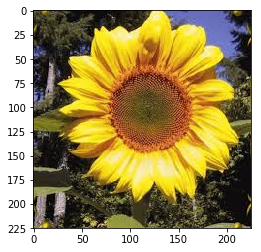

In [15]:
image = Image.open(IMAGE_PATH)

plt.imshow(image)

width = int(tf_input.shape.as_list()[1])
height = int(tf_input.shape.as_list()[2])

image = np.array(image.resize((width, height)))

### Execute model

In [16]:
output = tf_sess.run(tf_output, feed_dict={
    tf_input: image[None, ...]
})

scores = output[0]

### Get top 5 labels

In [17]:
with open(LABELS_PATH, 'r') as f:
    labels = f.readlines()

top5_idx = scores.argsort()[::-1][0:5]

for i in top5_idx:
    print('(%3f) %s' % (scores[i], labels[i]))

(0.870761) daisy

(0.047987) bee

(0.011623) sulphur butterfly, sulfur butterfly

(0.009787) earthstar

(0.009087) fly



### Close session to release resources

In [13]:
tf_sess.close()